Velocities for reference stars--these velocities *should* all be zero with an ideal instrument. 

- Show an example of what the data table looks like
- What are the sources of the velocity data over time? (show three different colors for three different reference stars)
- What is the histogram like for each reference star?
- What does the histogram look like of the velocities all together?
- How do the velocity error and stellar activity correlate with the velocity?

Telemetry

- What does the telemetry data look like? (show example table)
- What days over the four years does the telemetry data fall on? (show number of seconds/night as a function of date).
- What fraction of velocity records have an associated telemetry record?
- Plot velocities vs basically all the telemetry channels, using nearby times. 
- Calculate correlations between velocities and the same.
- Calculate some new quantities, also: delta-temperature for a night; frequency and amplitude of oscillation.
- Finally, train some neural networks to predict what the telescope telemetry looks like when the velocity is high. 

In [86]:
import os
from os import path
import sqlite3
global_sqlite_filename='apf.db'
import pandas
from datetime import datetime, timedelta
import numpy as np
from astropy.time import Time
from sqlalchemy import create_engine
import pytz
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

In [375]:
data = pandas.read_csv('final_data.csv')
print(data.columns)

# clean data of bad temperature records.
data = data.mask(data['TAVERAGE'] == 381.03)
data = data.mask(data['stellar_activity1'] == -1)


Index(['DateTimeLocal', 'YearMonthDayHour', 'EpocSeconds',
       'exposure_begin_datetime', 'exposure_end_datetime', 'velocity',
       'velocity_error', 'stellar_activity1', 'stellar_activity2',
       'total_counts', 'brad_doesnt_know', 'DateTimeUTC', 'starID', 'MIDPTFIN',
       'AZ', 'EL', 'AZENCPOS', 'ELENCPOS', 'AZENCVEL', 'ELENCVEL', 'AZFLWERR',
       'ELFLWERR', 'OUTFILE', 'OBSNUM', 'MODE', 'AVG_FWHM', 'M5WIND',
       'M5WINDAZ', 'TAVERAGE', 'TM1S210', 'TM2CAIR', 'OFFSET_AZ', 'OFFSET_EL',
       'RMSOFFSET_AZ', 'RMSOFFSET_EL', 'AVGOFFSET_AZ', 'AVGOFFSET_EL',
       'HATCHPOS', 'Delta_temp_from_begin_night'],
      dtype='object')


<Figure size 880x880 with 0 Axes>

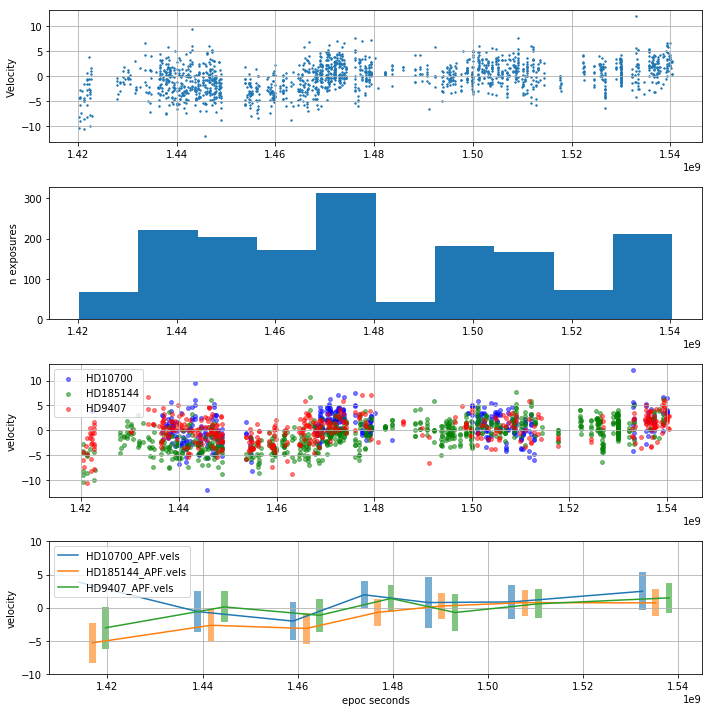

In [278]:
plot_df = pandas.DataFrame([['HD10700_APF.vels', 'b'], ['HD185144_APF.vels', 'g'], 
                            ['HD9407_APF.vels', 'r']], columns=['starID', 'color'])


def make_time_dist(ax, bin_edges, starID=None, starcolor=None):
    width = 2000000 * 0.7
    for i, starID in enumerate(['HD10700_APF.vels', 'HD185144_APF.vels', 'HD9407_APF.vels']):
        time = data.loc[data['starID'] == starID].EpocSeconds
        velocity = data.loc[data['starID'] == starID].velocity
    
        cut, bins = pandas.cut(time, bin_edges, retbins=True) 
        analysis = velocity.groupby(cut).agg(['mean', 'std'])
        


        mean_plus_std = analysis['mean'] + analysis['std']
        mean_minus_std = analysis['mean'] - analysis['std']
    
        x_vals = bins[:-1] + 0.5 * (-bins[:-1] + bins[1:]) + i * width*2
        ax.bar(x_vals, height = 2 * analysis['std'], width=width,
                    bottom = mean_minus_std, alpha=0.6, align='center',
                      label='_nolegend_')
        
        ax.plot(x_vals, analysis['mean'], label=starID)
       
    ax.grid()
    ax.legend(loc='upper left')
    
    


figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
opacity = 0.5
shape = 'circle'
fig, axs = plt.subplots(4, 1)
axs[0].set_ylabel("Velocity")
axs[0].grid()
axs[0].scatter(data.EpocSeconds, data.velocity, s=2)
axs[1].hist(data.EpocSeconds); axs[1].set_ylabel('n exposures')
#axs[2].scatter(data.EpocSeconds, [])
axs[2].scatter(data.loc[data['starID'] == 'HD10700_APF.vels'].EpocSeconds, 
               data.loc[data['starID'] == 'HD10700_APF.vels'].velocity,
                s=15, c='b', label='HD10700', alpha=opacity)
axs[2].scatter(data.loc[data['starID'] == 'HD185144_APF.vels'].EpocSeconds, 
               data.loc[data['starID'] == 'HD185144_APF.vels'].velocity, 
                s=15, c='g', label='HD185144', alpha=opacity)
axs[2].scatter(data.loc[data['starID'] == 'HD9407_APF.vels'].EpocSeconds, 
               data.loc[data['starID'] == 'HD9407_APF.vels'].velocity, 
                s=15, c='r', label='HD9407', alpha=opacity)
axs[2].legend(loc='upper left');
axs[2].set_ylabel('velocity')
axs[2].grid()
axs[3].set_xlabel('epoc seconds')
make_time_dist(axs[3], bin_edges=[1.4e9, 1.428e9, 1.45e9, 1.468e9, 1.48e9, 1.495e9, 1.515e9, 1.55e9])
axs[3].set_ylabel('velocity')
axs[3].set_ylim(-10,10)

fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()


In [285]:
def make_3d_histogram(bins, starID, starcolor):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('time')
    ax.set_ylabel('velocity')
    ax.set_ylim([10,-10])
    ax.view_init(50, 200)
    x, y = (data.loc[data['starID'] == starID].EpocSeconds, 
            data.loc[data['starID'] == starID].velocity)
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins)
    
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)

    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=starcolor, zsort='average')
    #fig.set_title(starID)
    
    fig.suptitle(starID, fontsize=16)
    plt.show()
    
#make_3d_histogram(bins=[5, 10], starID='HD10700_APF.vels', starcolor='b')
#make_3d_histogram(bins=[5, 10], starID='HD185144_APF.vels', starcolor='g')
#make_3d_histogram(bins=[5, 10], starID='HD9407_APF.vels', starcolor='black')

In [374]:
#np.abs(data.corr()['velocity']).sort_values(0, ascending=False).index
#data.corr()['velocity'].index
data.loc[data['stellar_activity1'] == -1]
#data = data.mask(data['TAVERAGE'] == 381.03)
#data['TAVERAGE'].sort_values(0, ascending=False)

,DateTimeLocal,YearMonthDayHour,EpocSeconds,exposure_begin_datetime,exposure_end_datetime,velocity,velocity_error,stellar_activity1,stellar_activity2,total_counts,...,TM1S210,TM2CAIR,OFFSET_AZ,OFFSET_EL,RMSOFFSET_AZ,RMSOFFSET_EL,AVGOFFSET_AZ,AVGOFFSET_EL,HATCHPOS,Delta_temp_from_begin_night
1057,2018-03-29T04:28:58.079984,2018-03-29-04,1.522298e+09,2018-03-29T04:26:56.7882,2018-03-29T04:30:56.6932,0.83,1.15,-1.0,0.0,40044.0,...,13.82,11.66,-0.160,0.174,0.288,0.364,0.001,0.001,Open,NaN
1058,2018-03-29T04:33:05.183975,2018-03-29-04,1.522298e+09,2018-03-29T04:31:44.0269,2018-03-29T04:34:35.0495,2.88,1.31,-1.0,0.0,21200.0,...,13.83,11.67,-0.414,-0.536,0.337,0.352,-0.001,-0.007,Open,NaN
1059,2018-03-29T04:36:53.279982,2018-03-29-04,1.522298e+09,2018-03-29T04:35:21.0338,2018-03-29T04:38:23.0334,4.09,1.18,-1.0,0.0,24296.0,...,13.82,11.56,0.673,-0.345,0.314,0.359,0.002,-0.001,Open,NaN
1060,2018-03-29T04:40:39.648016,2018-03-29-04,1.522298e+09,2018-03-29T04:39:10.0411,2018-03-29T04:41:53.7411,1.62,1.29,-1.0,0.0,20410.0,...,13.83,11.68,0.157,0.022,0.320,0.357,0.000,-0.002,Open,NaN
1061,2018-03-29T04:43:55.776021,2018-03-29-04,1.522299e+09,2018-03-29T04:42:39.0293,2018-03-29T04:45:19.0300,4.16,1.32,-1.0,0.0,20362.0,...,13.83,11.84,0.800,-0.157,0.337,0.365,0.005,-0.003,Open,NaN
1062,2018-03-29T04:47:17.088025,2018-03-29-04,1.522299e+09,2018-03-29T04:46:05.0436,2018-03-29T04:48:27.0322,2.51,1.31,-1.0,0.0,16805.0,...,13.83,11.68,-0.356,0.359,0.359,0.371,0.000,0.000,Open,NaN


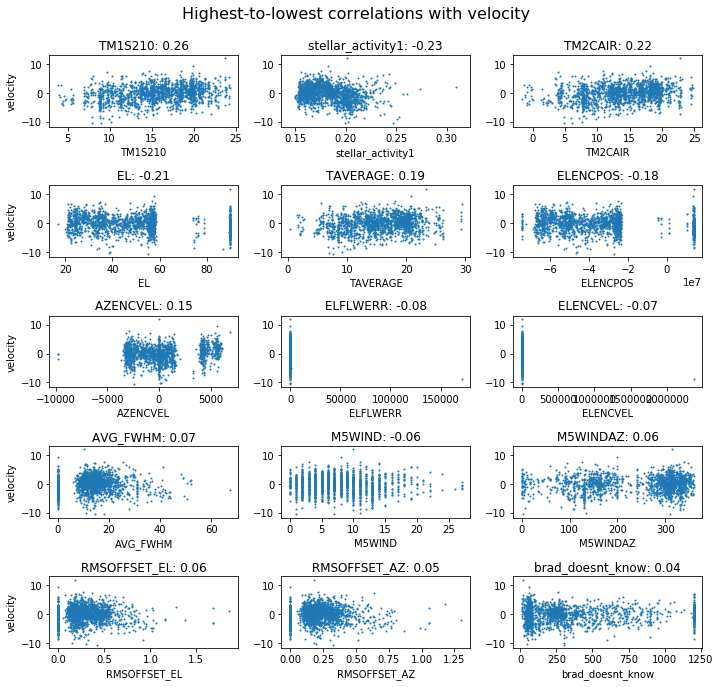

In [376]:
def make_correlations_exploring_plot(limit=15):
    correlations = data.corr()['velocity']
    sorted_correlations_list = np.abs(correlations).sort_values(0, ascending=False)[3:-2]
    index = sorted_correlations_list.index
    rows = int(np.floor(limit/3))
    fig, axarr = plt.subplots(rows, 3)
    sorted_correlations_list = sorted_correlations_list[:rows*3]

    for i, (name, correlation) in enumerate(sorted_correlations_list.iteritems()):
        row = int(np.floor(i/3)); col = i%3
        ax = axarr[row, col]
        ax.scatter(data[name], data['velocity'], s=1)
        if col == 0:
            ax.set_ylabel('velocity')
        #p = np.polyfit(data[name], data['velocity'], deg=5)
        #print(name, p)
        #x = np.arange(data[name].min(), data[name].max(), 100)
        #ax.plot(x, np.polyval(p, x), c='r')
        ax.set_xlabel(name)
        ax.set_title('{}: {}'.format(name, round(correlations[name], 2)))
        ax.autoscale()
    
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig.suptitle('Highest-to-lowest correlations with velocity', size=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
make_correlations_exploring_plot()